# Week 9: Dropout

In [77]:
# Load the dataset...
import torch
from pathlib import Path
from torch import nn
import sys
import numpy as np
from sklearn.datasets import fetch_openml
import torch.utils.data as data_utils
from sklearn.model_selection import train_test_split
from torch import optim
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms

%matplotlib inline

if("dataset" not in globals()):
    root_dir = Path().resolve()
    dataset = torchvision.datasets.MNIST(root_dir, download=True, transform=transforms.ToTensor())
    train, test = torch.utils.data.random_split(dataset, [int(len(dataset) * 0.8), int(len(dataset) * 0.2)])

First, load in MNIST and display a character:

In [88]:
!pip install nodejs
!jupyter labextension install @jupyter-widgets/jupyterlab-manager
!jupyter labextension install jupyter-matplotlib

usage: jupyter [-h] [--version] [--config-dir] [--data-dir] [--runtime-dir]
               [--paths] [--json] [--debug]
               [subcommand]

Jupyter: Interactive Computing

positional arguments:
  subcommand     the subcommand to launch

optional arguments:
  -h, --help     show this help message and exit
  --version      show the versions of core jupyter packages and exit
  --config-dir   show Jupyter config dir
  --data-dir     show Jupyter data dir
  --runtime-dir  show Jupyter runtime dir
  --paths        show all Jupyter paths. Add --json for machine-readable
                 format.
  --json         output paths as machine-readable json
  --debug        output debug information about paths

Available subcommands: bundlerextension console execute kernel kernelspec
migrate nbconvert nbextension notebook qtconsole run serverextension
troubleshoot trust

Jupyter command `jupyter-labextension` not found.
usage: jupyter [-h] [--version] [--config-dir] [--data-dir] [--runtime-di

Image Size: (1, 28, 28)


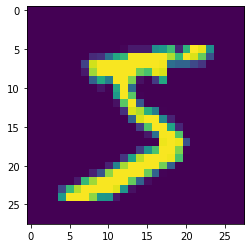

In [84]:
print("Image Size:", tuple(dataset[0][0].shape))
plt.imshow(dataset[0][0].moveaxis(0, -1));

In [13]:
is_cuda = torch.cuda.is_available()

if is_cuda:
    device = torch.device("cuda") # GPU
else:
    device = torch.device("cpu") # CPU
    
print(f"Running PyTorch Using: {device}")

Running PyTorch Using: cuda


In [14]:
batch_size = 100

to_device = lambda a: a.to(device)

test_loader = torch.utils.data.DataLoader(test, batch_size, shuffle=True)
train_loader = torch.utils.data.DataLoader(train, batch_size, shuffle=True)

In [15]:
# Functions for training a model...
def train_model(
    model, 
    train_data, 
    test_data, 
    optimizer, 
    error_func, 
    n_epochs,
    device,
    print_every=100,
    print_accuracy=True
):
    for epoch_i in range(1, n_epochs + 1):
        model.train()
        for i, (img, label) in enumerate(train_data, 1):
            # Zero gradients...
            model.zero_grad()
            # Run model...
            predicted = model.forward(img.to(device))
            
            # Compute loss, backpropigate, and optimize the weights...
            loss = error_func(predicted, label.to(device))
            loss.backward()
            optimizer.step()
            
            if((i % print_every == 0) or (i == len(train_data))):
                print(f"Epoch: {epoch_i}/{n_epochs}, Iter: {i}/{len(train_data)}, Loss: {loss:.04f}")
                
        # Run against the test set and train set at the end of each epoch to get accuracy...
        if(print_accuracy):
            model.eval()
            acc1 = get_accuracy(model, train_data)
            print(f"Epoch {epoch_i} Train Accuracy: {acc1 * 100:.02f}%")
            acc2 = get_accuracy(model, test_data)
            print(f"Epoch {epoch_i} Test Accuracy: {acc2 * 100:.02f}%\n")
    
    return model
        
        
def get_accuracy(model, data):
        run = 0
        correct = 0
        
        for img, label in data:
            run += len(img)
            result = model.forward(img.to(device)).cpu().detach().numpy()
            correct += np.sum(np.argmax(result, axis=1) == label.cpu().detach().numpy())
        
        return correct / run

### Model Without Dropout

Our first model will be a regular MLP classifying MNIST digits without dropout. Recall that in this network, all neurons (or nodes) will be present for every training case.

In [16]:
class VanillaNN(nn.Module):
    def __init__(self, input_size: tuple, hidden_layer_sizes: list, class_count: int): 
        super().__init__()
        layers = [
            nn.Linear(np.prod(input_size), hidden_layer_sizes[0]),
            nn.LeakyReLU()
        ]
        
        for this_size, next_size in zip(hidden_layer_sizes[:-1], hidden_layer_sizes[1:]):
            layers.extend([
                nn.Linear(this_size, next_size),
                nn.LeakyReLU()
            ])
            
        layers.append(nn.Linear(hidden_layer_sizes[-1], class_count))
        
        self._linear_layers = nn.Sequential(*layers)
        self._softmax = nn.Softmax(-1)
        
    def linear_layer(self, index: int):
        return self._linear_layers[index * 2]
        
    def forward(self, x: torch.tensor, exec_depth: int = None) -> torch.tensor:
        if(exec_depth is None):
            return self._softmax(self._linear_layers(x.reshape(x.shape[0], -1)))
        else:
            # Return internal values exec_layers layers in...
            return self._linear_layers[:exec_depth * 2](x.reshape(x.shape[0], -1))

In [57]:
#TODO: Below, set the number of hidden units per layer and number of output classes
hidden_layers = [64, 128, 128, 128, 128, 64] # this should be an array with units per hidden layer
num_classes = 10

vnn = VanillaNN(dataset[0][0].shape, hidden_layers, num_classes).to(device)
print(vnn)

VanillaNN(
  (_linear_layers): Sequential(
    (0): Linear(in_features=784, out_features=64, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Linear(in_features=128, out_features=128, bias=True)
    (7): LeakyReLU(negative_slope=0.01)
    (8): Linear(in_features=128, out_features=128, bias=True)
    (9): LeakyReLU(negative_slope=0.01)
    (10): Linear(in_features=128, out_features=64, bias=True)
    (11): LeakyReLU(negative_slope=0.01)
    (12): Linear(in_features=64, out_features=10, bias=True)
  )
  (_softmax): Softmax(dim=-1)
)


In [47]:
# TODO: Set epochs and learning rate. Be sure the network's performance has begun to plateau for a good comparison
n_epochs = 10
lr = 5e-4

# Set up everything...
optimizer = optim.Adam(vnn.parameters(), lr=lr)
loss_func = nn.CrossEntropyLoss()

In [48]:
vnn = train_model(vnn, train_loader, test_loader, optimizer, loss_func, n_epochs, device)

Epoch: 1/10, Iter: 100/480, Loss: 1.8282
Epoch: 1/10, Iter: 200/480, Loss: 1.7061
Epoch: 1/10, Iter: 300/480, Loss: 1.7296
Epoch: 1/10, Iter: 400/480, Loss: 1.8466
Epoch: 1/10, Iter: 480/480, Loss: 1.7243
Epoch 1 Train Accuracy: 74.02%
Epoch 1 Test Accuracy: 73.62%

Epoch: 2/10, Iter: 100/480, Loss: 1.6603
Epoch: 2/10, Iter: 200/480, Loss: 1.7552
Epoch: 2/10, Iter: 300/480, Loss: 1.7356
Epoch: 2/10, Iter: 400/480, Loss: 1.6767
Epoch: 2/10, Iter: 480/480, Loss: 1.5962
Epoch 2 Train Accuracy: 81.42%
Epoch 2 Test Accuracy: 81.23%

Epoch: 3/10, Iter: 100/480, Loss: 1.7168
Epoch: 3/10, Iter: 200/480, Loss: 1.6260
Epoch: 3/10, Iter: 300/480, Loss: 1.6470
Epoch: 3/10, Iter: 400/480, Loss: 1.7447
Epoch: 3/10, Iter: 480/480, Loss: 1.6386
Epoch 3 Train Accuracy: 84.04%
Epoch 3 Test Accuracy: 83.71%

Epoch: 4/10, Iter: 100/480, Loss: 1.6200
Epoch: 4/10, Iter: 200/480, Loss: 1.6701
Epoch: 4/10, Iter: 300/480, Loss: 1.5936
Epoch: 4/10, Iter: 400/480, Loss: 1.6094
Epoch: 4/10, Iter: 480/480, Loss: 1

In [49]:
print(f"Final Model Test Accuracy: {get_accuracy(vnn, test_loader) * 100:.02f}%")

Final Model Test Accuracy: 95.18%


### Model With Dropout

Now, let's try the same network with dropout. Dropout is simple: For every layer, the input to any given neuron is zeroed out with probability *p*. When a neuron's input is zeroed out, it's effectively removed from the model. Which neurons are dropped are determined by a vector of 1's and 0's generated by a Bernoulli distribution (at least, in the paper) for each training case.

Notably, dropout effectively turns a single model into an ensemble of models that share weights, where each model in the ensemble is a random subnetwork that only rarely gets trained.

**TODO: How many subnetworks are possible in a network with *n* units?**


2^n networks

**TODO: How does dropout change the relationship of units in the network with their neighbors?**


Any given unit may have a new "neighbor" model to model (put another way, neighbors may disappear model to model)

In [54]:
class DropoutNN(nn.Module):
    def __init__(
        self, 
        input_size: tuple, 
        hidden_layer_sizes: list, 
        dropout_values: list, 
        class_count: int
    ):
        super().__init__()
        layers = [
            #TODO: Add dropout here (hint: there's a PyTorch function for it).
            #Which value from the dropout list should go here?
            nn.Dropout(dropout_values[0]),
            nn.Linear(np.prod(input_size), hidden_layer_sizes[0]),
            nn.LeakyReLU()
        ]
        
        for this_size, next_size, dv in zip(hidden_layer_sizes[:-1], hidden_layer_sizes[1:], dropout_values[1:]):
            layers.extend([
                #TODO: Add dropout here too
                nn.Dropout(dv),
                nn.Linear(this_size, next_size),
                nn.LeakyReLU()
            ])
            
        layers.extend([
            #TODO: Last dropout call here. Which value should it take?
            nn.Dropout(int(np.mean(dropout_values))),
            nn.Linear(hidden_layer_sizes[-1], class_count)
        ])
        
        self._linear_layers = nn.Sequential(*layers)
        self._softmax = nn.Softmax(-1)
        
    def linear_layer(self, index: int):
        return self._linear_layers[index * 3 + 1]
        
    def forward(self, x: torch.tensor, exec_depth: int = None) -> torch.tensor:
        if(exec_depth is None):
            return self._softmax(self._linear_layers(x.reshape(x.shape[0], -1)))
        else:
            # Return internal values exec_layers layers in...
            return self._linear_layers[:exec_depth * 3](x.reshape(x.shape[0], -1))

In [59]:
# TODO: Specify number of hidden units per layer, per-layer dropout probability (between 0 and 1), and number of 
# output classes. How many per-layer dropout probabilities does this model require?
# hidden_layers = [256, 512, 512, 512, 512, 256]
dropout_probs = [0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
num_classes = 10

dnn = DropoutNN(dataset[0][0].shape, hidden_layers, dropout_probs, num_classes).to(device)
print(dnn)

DropoutNN(
  (_linear_layers): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=784, out_features=64, bias=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=64, out_features=128, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Dropout(p=0.5, inplace=False)
    (7): Linear(in_features=128, out_features=128, bias=True)
    (8): LeakyReLU(negative_slope=0.01)
    (9): Dropout(p=0.5, inplace=False)
    (10): Linear(in_features=128, out_features=128, bias=True)
    (11): LeakyReLU(negative_slope=0.01)
    (12): Dropout(p=0.5, inplace=False)
    (13): Linear(in_features=128, out_features=128, bias=True)
    (14): LeakyReLU(negative_slope=0.01)
    (15): Dropout(p=0.5, inplace=False)
    (16): Linear(in_features=128, out_features=64, bias=True)
    (17): LeakyReLU(negative_slope=0.01)
    (18): Dropout(p=0, inplace=False)
    (19): Linear(in_features=64, out_features=10, bias=True)
  )
  (

In [60]:
# TODO: Set epochs and learning rate. Note that dropout substantially slows down training!
n_epochs2 = 20
lr2 = 5e-4

# Set up everything...
optimizer2 = optim.Adam(dnn.parameters(), lr=lr2)
loss_func2 = nn.CrossEntropyLoss()

In [61]:
dnn = train_model(dnn, train_loader, test_loader, optimizer2, loss_func2, n_epochs2, device)

Epoch: 1/20, Iter: 100/480, Loss: 2.2756
Epoch: 1/20, Iter: 200/480, Loss: 2.1795
Epoch: 1/20, Iter: 300/480, Loss: 2.0243
Epoch: 1/20, Iter: 400/480, Loss: 1.9609
Epoch: 1/20, Iter: 480/480, Loss: 1.9084
Epoch 1 Train Accuracy: 53.69%
Epoch 1 Test Accuracy: 53.83%

Epoch: 2/20, Iter: 100/480, Loss: 1.9767
Epoch: 2/20, Iter: 200/480, Loss: 1.8807
Epoch: 2/20, Iter: 300/480, Loss: 1.9322
Epoch: 2/20, Iter: 400/480, Loss: 1.8878
Epoch: 2/20, Iter: 480/480, Loss: 1.8469
Epoch 2 Train Accuracy: 69.20%
Epoch 2 Test Accuracy: 69.84%

Epoch: 3/20, Iter: 100/480, Loss: 1.8422
Epoch: 3/20, Iter: 200/480, Loss: 1.8495
Epoch: 3/20, Iter: 300/480, Loss: 1.8540
Epoch: 3/20, Iter: 400/480, Loss: 1.8575
Epoch: 3/20, Iter: 480/480, Loss: 1.7706
Epoch 3 Train Accuracy: 77.93%
Epoch 3 Test Accuracy: 77.38%

Epoch: 4/20, Iter: 100/480, Loss: 1.7767
Epoch: 4/20, Iter: 200/480, Loss: 1.7971
Epoch: 4/20, Iter: 300/480, Loss: 1.7071
Epoch: 4/20, Iter: 400/480, Loss: 1.7839
Epoch: 4/20, Iter: 480/480, Loss: 1

In [62]:
dnn.eval()
print(f"Final Model Test Accuracy: {get_accuracy(dnn, test_loader) * 100:.02f}%")

Final Model Test Accuracy: 89.37%


In the interest of time: if the dropout model performs slightly worse than or equivalent to the vanilla model, there should still be clear differences in the layers visualized below. If you have the time, experiment with the number of epochs, learning rate, and dropout probabillities to maximize the dropout model's performance, then compare against the vanilla model.

**TODO: How does the training rate of the dropout model compare to the vanilla model? Why does dropout have this effect on training rates?**


So epoch-to-epoch, the dropout network is obviously faster since fewer nodes are considered, but overall time required for training is significantly higher relative to Vanilla (to account for fewer nodes considered).

### Visualizing Model Layers

Now, let's visualize the first layer weights from both models:

In [63]:
def plot_first_hidden_layer(
    model: nn.Module, 
    title: str, 
    height: int, 
    width: int, 
    depth: int, 
    num_samples: int = 10
):
    # Get the weights...
    weight = model.linear_layer(0).weight
    # Detach them and reshape them into the image size...
    weight = weight.cpu().detach().numpy().reshape(-1, depth, height, width)
        
    fig, axs = plt.subplots(depth, num_samples, squeeze=False)
    fig.set_size_inches(3 * num_samples, 3 * depth)
    fig.suptitle(title)
    
    selected_filters = np.random.choice(len(weight), num_samples, replace=False)
    for i, sub_axs in zip(selected_filters, axs.T):
        img = weight[i]
        
        for j, ax in enumerate(sub_axs):
            ax.set_title(f"Cell {i}, Channel {j}")
            ax.imshow(img[j])
    
    fig.tight_layout()
    fig.show()

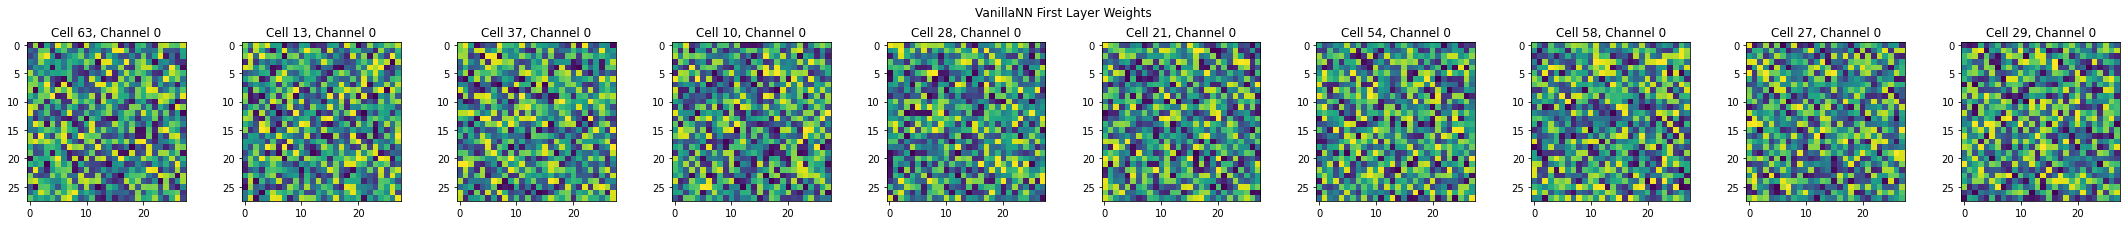

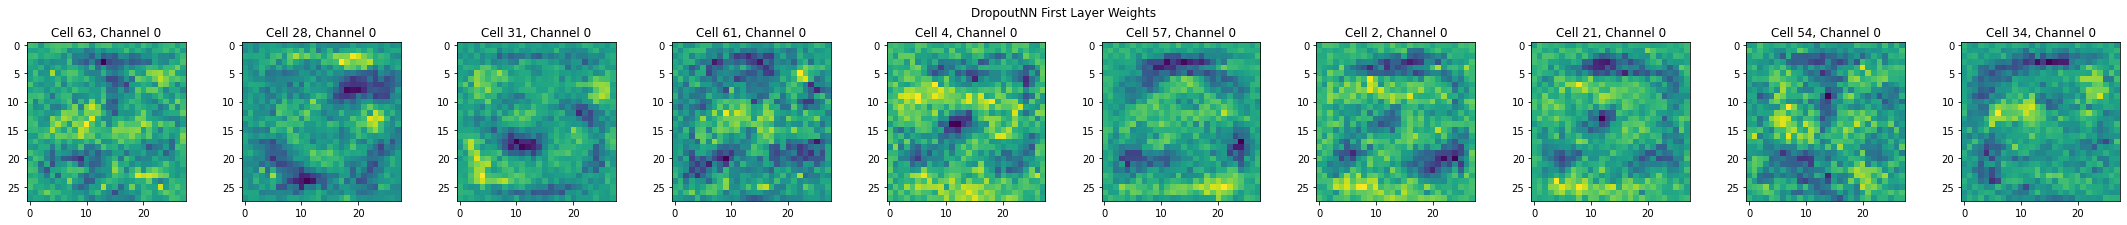

In [64]:
%matplotlib inline

d, h, w = dataset[0][0].shape
plot_first_hidden_layer(vnn, "VanillaNN First Layer Weights", h, w, d)
plot_first_hidden_layer(dnn, "DropoutNN First Layer Weights", h, w, d)

Double click on each row of plots to make them larger!

**TODO: Are there visual differences between the vanilla and dropout model weights? How does dropout cause these differences in the weights?**


Wow, yeah the first layer looks significantly different from vanilla to dropout. The vanilla layer appears noisier, while the dropout layer as much smoother areas of high/low signal.

# Optimal Images 

Below, we choose random individual neurons from the 'vanilla' net and the dropout net. For each neuron, we train an optimal image to maximally activate its neuron, then display the optimal image.

In [65]:
def generate_optimal_image(
    model: nn.Module,
    run_through_layers: int,
    nodes: int,
    width: int,
    height: int,
    depth: int,
    device,
    learning_rate: int = 5e-4,
    epochs: int = 4500,
    optimize_range: bool = False
) -> np.ndarray:
    # Put model in evaluation mode, we only want to optimize the image...
    model.eval()
    # Create a random image...
    img = torch.randn(1, depth, height, width, device=device, requires_grad=True)
    optimizer = optim.Adam([img], lr=learning_rate)
    loss_func = nn.MSELoss()
    
    print(f"Optimize Values After Layer {model.linear_layer(run_through_layers - 1)}, Node: {nodes}")
    
    for i in range(epochs):
        # Zero gradients...
        if img.grad is not None:
            img.grad.detach_()
            img.grad.zero_()
        model.zero_grad()
        # Run model...
        predicted = model.forward(img, run_through_layers)
        
        mask = np.zeros(predicted.shape[1], bool)
        mask[nodes] = 1
        
        node_score = torch.min(predicted[0, mask])
        not_node_score = torch.max(predicted[0, ~mask])
        
        # Compute loss, backpropigate, and optimize the weights...
        # Our loss: Maximize the range between nodes of interest and other nodes
        loss = -node_score if(not optimize_range) else -node_score + not_node_score
        
        loss.backward()
        optimizer.step()
        
        # All images are made up of channels that range from 0 to 1, so clamp values within that range...
        with torch.no_grad():
            img.clamp_(0, 1)

        if((i % 500 == 0) or (i == (epochs - 1))):
            print(f"Epoch: {i}/{epochs}, Loss: {loss:.02f}")
            
    return img

def random_optimal_images_from(
    model: nn.Module, 
    layer: int, 
    num_samples: int,
    width: int, 
    height: int, 
    depth: int, 
    device,
    *args,
    **kwargs
) -> tuple:
    imgs = []
    samples = np.random.choice(model.linear_layer(layer - 1).weight.shape[0], num_samples, replace=False)
    %matplotlib notebook
    
    for i, sample in enumerate(samples):
        print(f"Working on image {i + 1}/{num_samples}")
        imgs.append(
            generate_optimal_image(model, layer, sample, height, width, depth, device, *args, **kwargs)
        )
    
    fig, axs = plt.subplots(depth, num_samples, squeeze=False)
    fig.set_size_inches(3 * num_samples, 3 * depth)
    fig.suptitle(type(model).__name__)
    
    for img, sample_i, sub_axs in zip(imgs, samples, axs.T):
        for j, ax in enumerate(sub_axs):
            img2 = img.cpu().detach().numpy()[0, j]
            ax.set_title(f"Layer {layer}, Node {sample_i}, Channel {j}")
            m = ax.imshow(img2, cmap="plasma") 
    
    fig.colorbar(m)
    fig.tight_layout()
    fig.show()
    
    return fig, axs, imgs, samples

In [66]:
%matplotlib inline
vanilla_res = random_optimal_images_from(vnn, 4, 10, h, w, d, device, optimize_range=True)[0]
dropout_res = random_optimal_images_from(dnn, 4, 10, h, w, d, device, optimize_range=True)[0]

Working on image 1/10
Optimize Values After Layer Linear(in_features=128, out_features=128, bias=True), Node: 114
Epoch: 0/4500, Loss: 0.15
Epoch: 500/4500, Loss: 0.09
Epoch: 1000/4500, Loss: 0.09
Epoch: 1500/4500, Loss: 0.08
Epoch: 2000/4500, Loss: 0.01
Epoch: 2500/4500, Loss: -0.02
Epoch: 3000/4500, Loss: -0.04
Epoch: 3500/4500, Loss: -0.08
Epoch: 4000/4500, Loss: -0.11
Epoch: 4499/4500, Loss: -0.12
Working on image 2/10
Optimize Values After Layer Linear(in_features=128, out_features=128, bias=True), Node: 60
Epoch: 0/4500, Loss: 0.14
Epoch: 500/4500, Loss: 0.10
Epoch: 1000/4500, Loss: 0.09
Epoch: 1500/4500, Loss: 0.09
Epoch: 2000/4500, Loss: 0.08
Epoch: 2500/4500, Loss: 0.08
Epoch: 3000/4500, Loss: 0.08
Epoch: 3500/4500, Loss: 0.08
Epoch: 4000/4500, Loss: 0.08
Epoch: 4499/4500, Loss: 0.08
Working on image 3/10
Optimize Values After Layer Linear(in_features=128, out_features=128, bias=True), Node: 99
Epoch: 0/4500, Loss: 0.13
Epoch: 500/4500, Loss: 0.11
Epoch: 1000/4500, Loss: 0.10


<IPython.core.display.Javascript object>

Working on image 1/10
Optimize Values After Layer Linear(in_features=128, out_features=128, bias=True), Node: 57
Epoch: 0/4500, Loss: 8.49
Epoch: 500/4500, Loss: 0.52
Epoch: 1000/4500, Loss: 0.28
Epoch: 1500/4500, Loss: 0.28
Epoch: 2000/4500, Loss: 0.28
Epoch: 2500/4500, Loss: 0.28
Epoch: 3000/4500, Loss: 0.28
Epoch: 3500/4500, Loss: 0.28
Epoch: 4000/4500, Loss: 0.28
Epoch: 4499/4500, Loss: 0.28
Working on image 2/10
Optimize Values After Layer Linear(in_features=128, out_features=128, bias=True), Node: 98
Epoch: 0/4500, Loss: 20.30
Epoch: 500/4500, Loss: 0.52
Epoch: 1000/4500, Loss: 0.45
Epoch: 1500/4500, Loss: 0.39
Epoch: 2000/4500, Loss: 0.32
Epoch: 2500/4500, Loss: -0.07
Epoch: 3000/4500, Loss: -0.09
Epoch: 3500/4500, Loss: -0.11
Epoch: 4000/4500, Loss: -0.13
Epoch: 4499/4500, Loss: -0.16
Working on image 3/10
Optimize Values After Layer Linear(in_features=128, out_features=128, bias=True), Node: 81
Epoch: 0/4500, Loss: 5.74
Epoch: 500/4500, Loss: 0.55
Epoch: 1000/4500, Loss: 0.45


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [79]:
# %matplotlib notebook
vanilla_res

<IPython.core.display.Javascript object>

In [80]:
%matplotlib inline
dropout_res

<IPython.core.display.Javascript object>

**TODO: Are there any differences between the 'vanilla' net optimal images and the dropout net optimal images? If so, what do you think led to these differences?**

**TODO: The above function allows you to randomly sample nodes from any layer of the network for generating optimal images (Currently set to layer 4, the final layer output). What results do you get when changing the layer optimal images are being generated for? How do the Vanilla NN and Dropout NN results compare and differ?**